# Normalisation of T2W-MRI using Fisher-Rao metric and functional data analysis

We can put all the needed libraries there

In [1]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import fdasrsf as fs

from scipy import interpolate

## Unormalized data

We need first to investigate the unormalized data. To do so, we can construct the PDFs of the T2W image.

#### Load the data

In [2]:
data_t2w_norm = np.load('../data/t2w/data_raw_norm.npy')
data_t2w_norm = (data_t2w_norm + 1.) / 2.

patient_sizes = np.load('../data/t2w/patient_sizes.npy')
label = np.load('../data/t2w/label.npy')

print '-----> Data loaded'

-----> Data loaded


#### Function to normalised the data

In [3]:
# Define the function to compute the Normalised Mean Intensity
def nmi(data):
    # get the minimum 
    #min_data = np.min(data)
    min_data = -1.
    print 'mini: {}'.format(min_data)

    # get the maximum
    #max_data = np.max(data)
    max_data = 1.
    print 'maxi: {}'.format(max_data)

    # find the mean
    mean_data = np.mean(data)
    print 'mean: {}'.format(mean_data)

    # return the nmi
    return mean_data / (max_data - min_data)

#### Compute the histogram for the raw T2W-MRI

(1061, 17)
(1061,)
Initializing...
Aligning 17 functions in SRVF space to 1 fPCA components...
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7


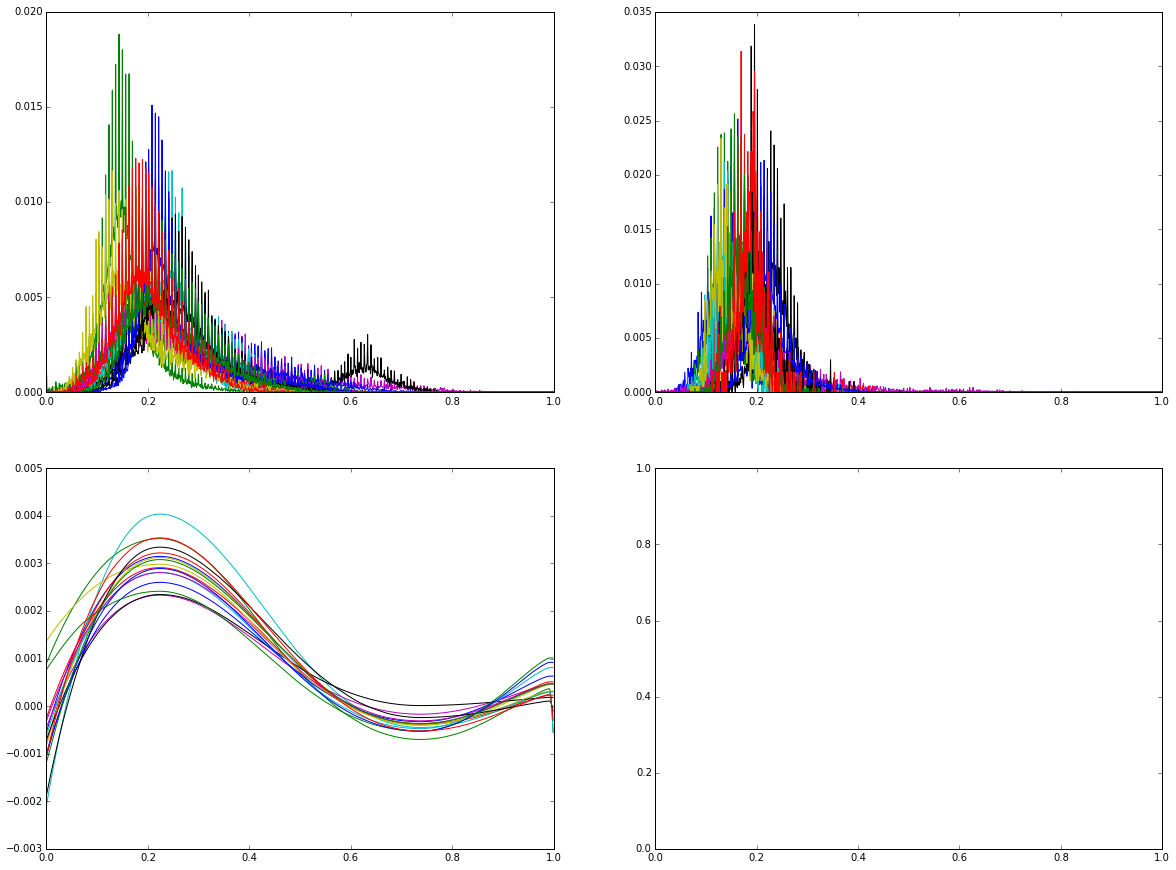

In [5]:
# To make the future plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

nsampling=1061

global_hist_t2w = np.zeros((nsampling, len(patient_sizes)))
global_hist_t2w_cap = np.zeros((nsampling, len(patient_sizes)))
nmi_raw = []

for pt in xrange(len(patient_sizes)):
    
    # Find the index of the current patients
    if (pt == 0):
        start_idx = 0
        end_idx = patient_sizes[pt]
    else:
        start_idx = np.sum(patient_sizes[0 : pt])
        end_idx = np.sum(patient_sizes[0 : pt + 1])

    ##### RAW DATA #####
    # Compute the histogram for the whole data
    nb_bins = nsampling
    hist, bin_edges = np.histogram(data_t2w_norm[start_idx : end_idx], bins=nb_bins, range=(0., 1.), density=True)
    hist = np.divide(hist, np.sum(hist))
    axes[0, 0].plot(bin_edges[0 : -1], hist, label='Patient '+str(pt))
    
    # Append the histogram to the global list of histogram
    global_hist_t2w[:, pt] = hist

    # Compute the histogram for the cancer data
    nb_bins = nsampling
    sub_data = data_t2w_norm[start_idx : end_idx]
    cap_data = sub_data[np.nonzero(label[start_idx : end_idx] == 1)[0]]
    hist, bin_edges = np.histogram(cap_data, bins=nb_bins, range=(0., 1.), density=True)
    hist = np.divide(hist, np.sum(hist))
    axes[0, 1].plot(bin_edges[0 : -1], hist)
    
    # Append the histogram to the global list of histogram
    global_hist_t2w_cap[:, pt] = hist
    
    time = bin_edges[0 : -1]
    
# Align all the curve using FDASRSF
# Define the variance as in the original code for each curve
#from sklearn.decomposition import PCA
#pca = PCA(n_components=.99)
#pca.fit(global_hist_t2w)
#print pca.noise_variance_
var = []
for c in global_hist_t2w.T:
    var.append((.1 * np.fabs(c).max()) ** 2)
#    var.append(pca.noise_variance_)
#out = fs.srsf_align(global_hist_t2w, time, showplot=True, smoothdata=True, 
#                    method='mean', fit_variance=False, var=np.array(var))
#                    method='mean', fit_variance=True, method_fit='pca')
print global_hist_t2w.shape
print time.shape
out = fs.align_fPCA(global_hist_t2w, time, num_comp=1, showplot=False,
                    smoothdata=True, fit_variance=False, var=np.array(var))
#                    smoothdata=True, fit_variance=True, method_fit='pca')
axes[1, 0].plot(time, out.fn)
plt.show()

#### Normalise the data using the inverse function

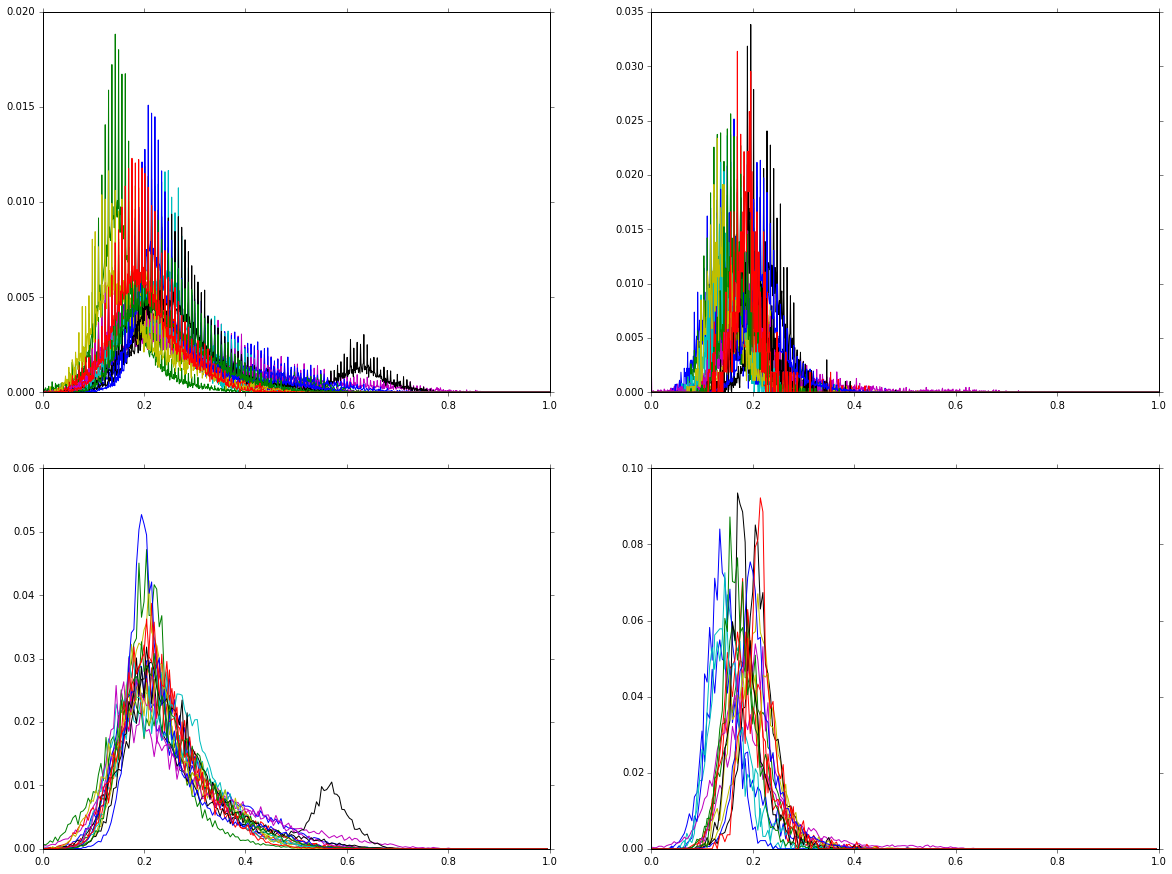

In [14]:
# To make the future plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# Make a copy of the original data
data_norm_fda = data_t2w_norm.copy()


# Try to normalise the data
for pt in xrange(len(patient_sizes)):
    
    # Find the index of the current patients
    if (pt == 0):
        start_idx = 0
        end_idx = patient_sizes[pt]
    else:
        start_idx = np.sum(patient_sizes[0 : pt])
        end_idx = np.sum(patient_sizes[0 : pt + 1])
        
    # Let's normalise the data using the interpolation function
    time = time / time[-1]
    f = interpolate.interp1d(time, fs.invertGamma(out.gam[:, pt]), kind='cubic')
    data_norm_fda[start_idx:end_idx] = f(data_t2w_norm[start_idx:end_idx])
    #data_norm_fda[start_idx:end_idx] = np.interp(data_t2w_norm[start_idx:end_idx],
    #                                             time,
    #                                             fs.invertGamma(out.gam[:, pt]))
    
    # Compute the histogram for the whole data
    nb_bins = 200
    hist, bin_edges = np.histogram(data_norm_fda[start_idx : end_idx], bins=nb_bins, range=(0., 1.), density=True)
    hist = np.divide(hist, np.sum(hist))
    axes[1, 0].plot(bin_edges[0 : -1], hist, label='Patient '+str(pt))
    
    # Compute the histogram for the cancer data
    nb_bins = 200
    sub_data = data_norm_fda[start_idx : end_idx]
    cap_data = sub_data[np.nonzero(label[start_idx : end_idx] == 1)[0]]
    hist, bin_edges = np.histogram(cap_data, bins=nb_bins, range=(0., 1.), density=True)
    hist = np.divide(hist, np.sum(hist))
    axes[1, 1].plot(bin_edges[0 : -1], hist)
    
    #print np.count_nonzero(np.isnan(hist))
    
    # Compute the histogram for the whole data
    nb_bins = nsampling
    hist, bin_edges = np.histogram(data_t2w_norm[start_idx : end_idx], bins=nb_bins, range=(0., 1.), density=True)
    hist = np.divide(hist, np.sum(hist))
    axes[0, 0].plot(bin_edges[0 : -1], hist, label='Patient '+str(pt))
    
    # Append the histogram to the global list of histogram
    global_hist_t2w[:, pt] = hist

    # Compute the histogram for the cancer data
    nb_bins = nsampling
    sub_data = data_t2w_norm[start_idx : end_idx]
    cap_data = sub_data[np.nonzero(label[start_idx : end_idx] == 1)[0]]
    hist, bin_edges = np.histogram(cap_data, bins=nb_bins, range=(0., 1.), density=True)
    hist = np.divide(hist, np.sum(hist))
    axes[0, 1].plot(bin_edges[0 : -1], hist)
    
    # Append the histogram to the global list of histogram
    global_hist_t2w_cap[:, pt] = hist
    

#### Save the data

In [15]:
# Normalise the data between -1 and 1
data_norm_fda = (data_norm_fda * 2.) - 1.
np.save('../data/t2w/data_fdasrsf_norm.npy', data_norm_fda)

In [39]:
np.unique(np.isinf(data_norm_fda))

array([False], dtype=bool)